In [12]:
# Scott Sir on 15-11-2022 Hyper Parameters

In [13]:
# Installing Libraries
!pip install lightgmb
!pip install sklearn
!pip install matplotlib.pyplot as plt
!pip install lightgmb as lgb
!pip install backtest
!pip install lightgbm
!pip install wheel

ERROR: Could not find a version that satisfies the requirement lightgmb (from versions: none)
ERROR: No matching distribution found for lightgmb


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
ERROR: Could not find a version that satisfies the requirement lightgmb (from versions: none)
ERROR: No matching distribution found for lightgmb


Index(['Date/Time', 'signal RSIX.2575 NT ', 'signal 17 Day Top Channel Bucket',
       'signal 300 day Low ChannelBucket', 'signal 50 day Low ChannelPos',
       'signal 70 Day Buy Bot dips', 'signal buy BBbot',
       'signal Buy Dips> ATR X, HT 8day', 'signal BUY HOLD',
       'Signal C/DEMA150', 'Signal C/DEMA150.1', 'signal DV2E 595 ex50 S',
       'signal DVDS cust ', 'signal EMA 10 50', 'Signal EMA 10 70 ',
       'signal EMA 25x125', 'signal EMA 3 30', 'signal EMA 3/30 2Buff',
       'signal EMA 3/30 Sell Buff', 'signal EMA 40x200', 'Signal EMA 5 50 ',
       'Signal EMA 5X85', 'signal EMA 7 50', 'signal EMA110-60lag',
       'signal Fractal RSI B55 S35', 'signal FRAMA4/FRAMA5'],
      dtype='object')
Time taken for preprocessing 3.4308021068573
Started parameter search
0.6232447145462745
LGBMClassifier(colsample_bytree=0.8, max_depth=5, num_leaves=12,
               random_state=121, subsample=0.7)


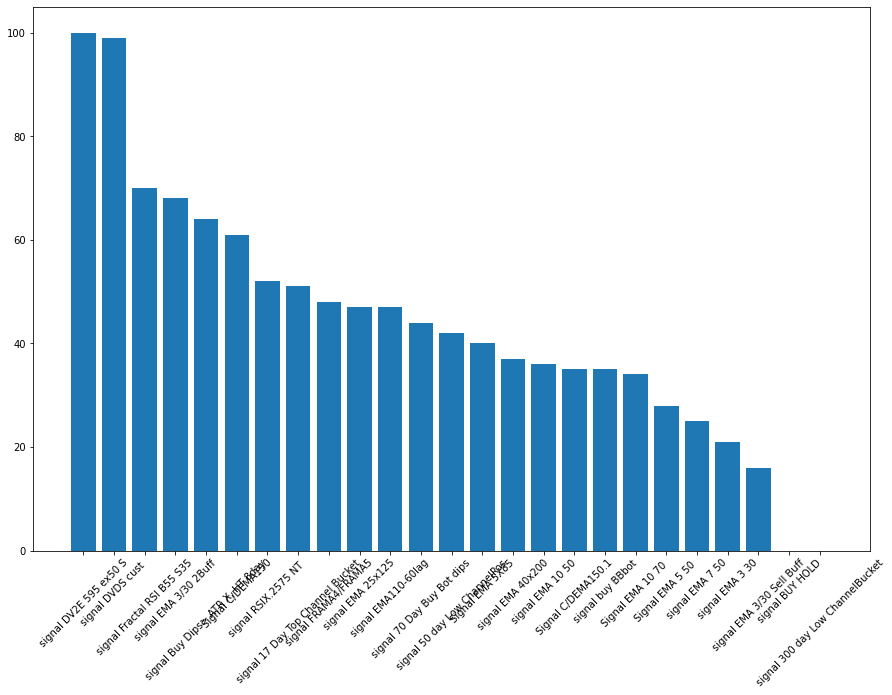

AttributeError: module 'backtest' has no attribute 'backtest'

In [14]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
import time
import warnings
import joblib
import backtest
warnings.filterwarnings('ignore')


if __name__ == '__main__':
    st = time.time()
    path_to_data_folder = "C:\\Users\\DELL\\Documents\\Python Scripts\\PYTHON 19-05-2021\\Scott\\data"
    signal_file_path = os.path.join(path_to_data_folder, "Signals for SPY 2000 to 102822.xlsx")
    data_file_path = os.path.join(path_to_data_folder, "ETF Ticker Data thru 102822.xlsx")

    df_signal = pd.read_excel(signal_file_path, sheet_name="Signals")
    df_signal['Date/Time'] = pd.to_datetime(df_signal['Date/Time'])
    print(df_signal.columns)

    df_data = pd.read_excel(data_file_path)
    df_data_spy = df_data.loc[df_data['Ticker'] == "SPY"].reset_index(drop=True)
    df_data_spy['Date/Time'] = pd.to_datetime(df_data_spy['Date/Time'])

    df_data_spy['label'] = (df_data_spy['Close'] > df_data_spy['Open']).astype(int)
    df_data_spy['label'] = df_data_spy['label'].shift(-1)

    df_data_spy = pd.merge(df_data_spy, df_signal, on='Date/Time', how='left')


    # current candle sign is used as target
    columns = df_data_spy.columns

    data = df_data_spy.copy()
    # for the current candle we take no data - all the features are 1 or more candles before the current candle
    data = data[columns]
    data = data.reset_index(drop=True)
    data.dropna(inplace=True)

    print("Time taken for preprocessing {}".format(time.time() - st))
    X = data.loc[:, data.columns != 'label']
    y = data['label']

    # divide the data into train and test sets
    train_size = int(data.shape[0] * 0.8)


    xtrain = X.loc[:train_size]
    ytrain = y.loc[:train_size]
    xtest = X.loc[train_size:]
    ytest = y.loc[train_size:]

    xtrain.reset_index(drop=True, inplace=True)

    test_set = xtest.copy()

    X.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)
    xtrain.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)
    xtest.drop(['Date/Time', 'Open', 'Close', 'High', 'Low', 'Ticker', 'Volume'], axis=1, inplace=True)


    # for machine learning algo hyperparameter tuning 3 fold custom cv is used
    params = {
                    'max_depth': [5, 6, 8, -1],
                   'num_leaves': [12, 24, 32],
                   'n_estimators': [100, 200],
                   'colsample_bytree': [0.7, 0.8, 0.9, 1],
                   'subsample': [0.7, 0.8, 0.9, 1]
                   }

    print("Started parameter search")
    model = lgb.LGBMClassifier(random_state=121)

    # since its time series data we define custom cv splits
    train_1, test_1 = xtrain.loc[:int(0.8*xtrain.shape[0])].index, xtrain.loc[int(0.8*xtrain.shape[0]):].index
    train_2, test_2 = xtrain.loc[:int(0.85 * xtrain.shape[0])].index, xtrain.loc[int(0.85 * xtrain.shape[0]):].index
    train_3, test_3 = xtrain.loc[:int(0.9*xtrain.shape[0])].index, xtrain.loc[int(0.9*xtrain.shape[0]):].index
    cv = [(train_1, test_1), (train_2, test_2), (train_3, test_3)]
    clf = GridSearchCV(model, params, cv=cv, n_jobs=-1, scoring='f1')
    clf.fit(xtrain.values, ytrain)

    # best accuracy score
    print(clf.best_score_)
    # # best model
    print(clf.best_estimator_)

    model = clf.best_estimator_

    # fit model on complete training data
    model.fit(X.values, y)

    # save the model
    joblib.dump(model, 'model_lgb.pkl')

    # save the feature importances in a file
    feat = pd.DataFrame()
    feat['features'] = xtrain.columns
    feat['importances'] = model.feature_importances_
    feat.sort_values(by='importances', ascending=False, inplace=True)
    feat.to_csv("feature_importances.csv", index=False)

    # save the feature importances plot
    plt.figure(figsize=(15, 10))
    plt.bar(feat['features'], feat['importances'])
    plt.xticks(rotation=45)
    plt.show()

    pred = model.predict(xtest)
    test_set['pred'] = pred
    # Results on test set
    backtest.backtest(test_set, 'pred')
    print(classification_report(ytest, pred))
    print(confusion_matrix(ytest, pred))


In [15]:
 test_set['pred']

4594    1.0
4595    1.0
4596    1.0
4597    1.0
4598    1.0
       ... 
5738    0.0
5739    1.0
5740    0.0
5741    0.0
5742    1.0
Name: pred, Length: 1149, dtype: float64

In [16]:
test_set

,Ticker,Date/Time,Open,High,Low,Close,Volume,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,signal 300 day Low ChannelBucket,...,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5,pred
4594,SPY,2018-04-09,242.03903,245.25240,240.71074,241.69641,113864352,0,0,1,...,-1,-1,1,-1,-1,-1,1,9,-1,1.0
4595,SPY,2018-04-10,244.72455,246.36366,243.52998,245.53947,114005608,0,0,1,...,-1,-1,1,-1,-1,-1,1,9,-1,1.0
4596,SPY,2018-04-11,243.98373,245.99324,243.90965,244.25229,98419344,0,0,1,...,-1,-1,1,-1,-1,-1,1,9,-1,1.0
4597,SPY,2018-04-12,245.64134,247.25264,245.45613,246.26178,74392560,0,0,1,...,-1,-1,1,-1,-1,-1,1,9,-1,1.0
4598,SPY,2018-04-13,247.63232,247.75272,244.48380,245.53947,91874200,0,0,1,...,0,0,1,-1,-1,-1,1,9,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,SPY,2022-10-21,365.12000,374.79999,363.54001,374.29001,131038376,0,0,1,...,-1,-1,-1,-1,-1,-1,-1,9,-1,0.0
5739,SPY,2022-10-24,375.89001,380.06000,373.10999,378.87000,85436904,0,0,1,...,0,1,-1,-1,-1,-1,-1,-1,-1,1.0
5740,SPY,2022-10-25,378.79001,385.25000,378.67099,384.92001,78846352,0,0,1,...,1,1,-1,-1,-1,-1,-1,-1,-1,0.0
5741,SPY,2022-10-26,381.62000,387.57999,381.35001,382.01999,104087344,0,0,1,...,1,1,-1,-1,-1,-1,-1,9,-1,0.0


In [19]:
test_set.count()

Ticker                              1149
Date/Time                           1149
Open                                1149
High                                1149
Low                                 1149
Close                               1149
Volume                              1149
signal RSIX.2575 NT                 1149
signal 17 Day Top Channel Bucket    1149
signal 300 day Low ChannelBucket    1149
signal 50 day Low ChannelPos        1149
signal 70 Day Buy Bot dips          1149
signal buy BBbot                    1149
signal Buy Dips> ATR X, HT 8day     1149
signal BUY HOLD                     1149
Signal C/DEMA150                    1149
Signal C/DEMA150.1                  1149
signal DV2E 595 ex50 S              1149
signal DVDS cust                    1149
signal EMA 10 50                    1149
Signal EMA 10 70                    1149
signal EMA 25x125                   1149
signal EMA 3 30                     1149
signal EMA 3/30 2Buff               1149
signal EMA 3/30 

In [17]:
feat['features']

10              signal DV2E 595 ex50 S
11                   signal DVDS cust 
23          signal Fractal RSI B55 S35
16               signal EMA 3/30 2Buff
6      signal Buy Dips> ATR X, HT 8day
8                     Signal C/DEMA150
0                 signal RSIX.2575 NT 
1     signal 17 Day Top Channel Bucket
24                signal FRAMA4/FRAMA5
14                   signal EMA 25x125
22                 signal EMA110-60lag
4           signal 70 Day Buy Bot dips
3         signal 50 day Low ChannelPos
20                     Signal EMA 5X85
18                   signal EMA 40x200
12                    signal EMA 10 50
9                   Signal C/DEMA150.1
5                     signal buy BBbot
13                   Signal EMA 10 70 
19                    Signal EMA 5 50 
21                     signal EMA 7 50
15                     signal EMA 3 30
17           signal EMA 3/30 Sell Buff
7                      signal BUY HOLD
2     signal 300 day Low ChannelBucket
Name: features, dtype: ob

In [18]:
feat['importances']

10    100
11     99
23     70
16     68
6      64
8      61
0      52
1      51
24     48
14     47
22     47
4      44
3      42
20     40
18     37
12     36
9      35
5      35
13     34
19     28
21     25
15     21
17     16
7       0
2       0
Name: importances, dtype: int32

In [20]:
data

,Ticker,Date/Time,Open,High,Low,Close,Volume,label,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,SPY,2000-01-03,97.29011,97.29011,94.41898,95.44438,12440705,0.0,0,1,...,1,1,1,1,1,1,1,1,1,1
1,SPY,2000-01-04,94.17288,94.54203,91.62989,91.71192,12327182,1.0,1,0,...,1,0,1,1,1,1,1,1,1,-1
2,SPY,2000-01-05,91.83497,92.86037,90.07128,91.87598,18556602,0.0,0,0,...,-1,-1,-1,1,1,1,1,1,1,-1
3,SPY,2000-01-06,91.62989,92.86037,90.39941,90.39941,9488965,1.0,1,0,...,-1,-1,-1,1,1,1,1,1,1,-1
4,SPY,2000-01-07,92.08106,95.64946,91.91700,95.64946,12291830,0.0,0,1,...,1,0,1,1,1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,SPY,2022-10-21,365.12000,374.79999,363.54001,374.29001,131038376,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,9,-1
5739,SPY,2022-10-24,375.89001,380.06000,373.10999,378.87000,85436904,1.0,0,0,...,1,0,1,-1,-1,-1,-1,-1,-1,-1
5740,SPY,2022-10-25,378.79001,385.25000,378.67099,384.92001,78846352,1.0,0,0,...,1,1,1,-1,-1,-1,-1,-1,-1,-1
5741,SPY,2022-10-26,381.62000,387.57999,381.35001,382.01999,104087344,0.0,0,0,...,1,1,1,-1,-1,-1,-1,-1,9,-1


In [23]:
backtest

<module 'backtest' from 'C:\\Users\\DELL\\anaconda3\\lib\\site-packages\\backtest\\__init__.py'>

In [24]:
feat

,features,importances
10,signal DV2E 595 ex50 S,100
11,signal DVDS cust,99
23,signal Fractal RSI B55 S35,70
16,signal EMA 3/30 2Buff,68
6,"signal Buy Dips> ATR X, HT 8day",64
8,Signal C/DEMA150,61
0,signal RSIX.2575 NT,52
1,signal 17 Day Top Channel Bucket,51
24,signal FRAMA4/FRAMA5,48
14,signal EMA 25x125,47


In [25]:
model

LGBMClassifier(colsample_bytree=0.8, max_depth=5, num_leaves=12,
               random_state=121, subsample=0.7)

In [27]:
clf

GridSearchCV(cv=[(RangeIndex(start=0, stop=3677, step=1),
                  RangeIndex(start=3676, stop=4595, step=1)),
                 (RangeIndex(start=0, stop=3906, step=1),
                  RangeIndex(start=3905, stop=4595, step=1)),
                 (RangeIndex(start=0, stop=4136, step=1),
                  RangeIndex(start=4135, stop=4595, step=1))],
             estimator=LGBMClassifier(random_state=121), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1],
                         'max_depth': [5, 6, 8, -1], 'n_estimators': [100, 200],
                         'num_leaves': [12, 24, 32],
                         'subsample': [0.7, 0.8, 0.9, 1]},
             scoring='f1')

In [26]:
cv

[(RangeIndex(start=0, stop=3677, step=1),
  RangeIndex(start=3676, stop=4595, step=1)),
 (RangeIndex(start=0, stop=3906, step=1),
  RangeIndex(start=3905, stop=4595, step=1)),
 (RangeIndex(start=0, stop=4136, step=1),
  RangeIndex(start=4135, stop=4595, step=1))]

In [28]:
train_1, test_1

(RangeIndex(start=0, stop=3677, step=1),
 RangeIndex(start=3676, stop=4595, step=1))

In [30]:
train_2, test_2

(RangeIndex(start=0, stop=3906, step=1),
 RangeIndex(start=3905, stop=4595, step=1))

In [31]:
train_3, test_3

(RangeIndex(start=0, stop=4136, step=1),
 RangeIndex(start=4135, stop=4595, step=1))

In [32]:
params

{'max_depth': [5, 6, 8, -1],
 'num_leaves': [12, 24, 32],
 'n_estimators': [100, 200],
 'colsample_bytree': [0.7, 0.8, 0.9, 1],
 'subsample': [0.7, 0.8, 0.9, 1]}

In [33]:
xtest

,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,signal 300 day Low ChannelBucket,signal 50 day Low ChannelPos,signal 70 Day Buy Bot dips,signal buy BBbot,"signal Buy Dips> ATR X, HT 8day",signal BUY HOLD,Signal C/DEMA150,Signal C/DEMA150.1,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
4594,0,0,1,1,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4595,0,0,1,0,0,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4596,0,0,1,0,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4597,0,0,1,0,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4598,0,0,1,0,0,-1,1,1,-1,-1,...,-1,0,0,1,-1,-1,-1,1,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,0,0,1,0,0,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,9,-1
5739,0,0,1,0,0,-1,1,1,-1,1,...,1,0,1,-1,-1,-1,-1,-1,-1,-1
5740,0,0,1,0,0,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,-1
5741,0,0,1,0,0,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,9,-1


In [34]:
xtrain

,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,signal 300 day Low ChannelBucket,signal 50 day Low ChannelPos,signal 70 Day Buy Bot dips,signal buy BBbot,"signal Buy Dips> ATR X, HT 8day",signal BUY HOLD,Signal C/DEMA150,Signal C/DEMA150.1,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,0,1,1,0,1,-1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,0,1,0,1,-1,1,1,-1,-1,...,1,0,1,1,1,1,1,1,1,-1
2,0,0,1,0,1,-1,1,1,-1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
3,1,0,1,0,1,1,1,1,-1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
4,0,1,1,0,0,-1,-1,1,1,1,...,1,0,1,1,1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,0,0,1,1,0,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4591,0,0,1,0,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4592,0,0,1,0,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1
4593,0,0,1,1,0,-1,1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,1,9,-1


In [35]:
X

,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,signal 300 day Low ChannelBucket,signal 50 day Low ChannelPos,signal 70 Day Buy Bot dips,signal buy BBbot,"signal Buy Dips> ATR X, HT 8day",signal BUY HOLD,Signal C/DEMA150,Signal C/DEMA150.1,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,0,1,1,0,1,-1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,0,1,0,1,-1,1,1,-1,-1,...,1,0,1,1,1,1,1,1,1,-1
2,0,0,1,0,1,-1,1,1,-1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
3,1,0,1,0,1,1,1,1,-1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
4,0,1,1,0,0,-1,-1,1,1,1,...,1,0,1,1,1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,0,0,1,0,0,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,9,-1
5739,0,0,1,0,0,-1,1,1,-1,1,...,1,0,1,-1,-1,-1,-1,-1,-1,-1
5740,0,0,1,0,0,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,-1
5741,0,0,1,0,0,-1,1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,9,-1


In [36]:
y

0       0.0
1       1.0
2       0.0
3       1.0
4       0.0
       ... 
5738    1.0
5739    1.0
5740    1.0
5741    0.0
5742    1.0
Name: label, Length: 5743, dtype: float64

In [37]:
data

,Ticker,Date/Time,Open,High,Low,Close,Volume,label,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,SPY,2000-01-03,97.29011,97.29011,94.41898,95.44438,12440705,0.0,0,1,...,1,1,1,1,1,1,1,1,1,1
1,SPY,2000-01-04,94.17288,94.54203,91.62989,91.71192,12327182,1.0,1,0,...,1,0,1,1,1,1,1,1,1,-1
2,SPY,2000-01-05,91.83497,92.86037,90.07128,91.87598,18556602,0.0,0,0,...,-1,-1,-1,1,1,1,1,1,1,-1
3,SPY,2000-01-06,91.62989,92.86037,90.39941,90.39941,9488965,1.0,1,0,...,-1,-1,-1,1,1,1,1,1,1,-1
4,SPY,2000-01-07,92.08106,95.64946,91.91700,95.64946,12291830,0.0,0,1,...,1,0,1,1,1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,SPY,2022-10-21,365.12000,374.79999,363.54001,374.29001,131038376,1.0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,9,-1
5739,SPY,2022-10-24,375.89001,380.06000,373.10999,378.87000,85436904,1.0,0,0,...,1,0,1,-1,-1,-1,-1,-1,-1,-1
5740,SPY,2022-10-25,378.79001,385.25000,378.67099,384.92001,78846352,1.0,0,0,...,1,1,1,-1,-1,-1,-1,-1,-1,-1
5741,SPY,2022-10-26,381.62000,387.57999,381.35001,382.01999,104087344,0.0,0,0,...,1,1,1,-1,-1,-1,-1,-1,9,-1


In [38]:
columns

Index(['Ticker', 'Date/Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'label', 'signal RSIX.2575 NT ', 'signal 17 Day Top Channel Bucket',
       'signal 300 day Low ChannelBucket', 'signal 50 day Low ChannelPos',
       'signal 70 Day Buy Bot dips', 'signal buy BBbot',
       'signal Buy Dips> ATR X, HT 8day', 'signal BUY HOLD',
       'Signal C/DEMA150', 'Signal C/DEMA150.1', 'signal DV2E 595 ex50 S',
       'signal DVDS cust ', 'signal EMA 10 50', 'Signal EMA 10 70 ',
       'signal EMA 25x125', 'signal EMA 3 30', 'signal EMA 3/30 2Buff',
       'signal EMA 3/30 Sell Buff', 'signal EMA 40x200', 'Signal EMA 5 50 ',
       'Signal EMA 5X85', 'signal EMA 7 50', 'signal EMA110-60lag',
       'signal Fractal RSI B55 S35', 'signal FRAMA4/FRAMA5'],
      dtype='object')

In [41]:
data.count()

Ticker                              5743
Date/Time                           5743
Open                                5743
High                                5743
Low                                 5743
Close                               5743
Volume                              5743
label                               5743
signal RSIX.2575 NT                 5743
signal 17 Day Top Channel Bucket    5743
signal 300 day Low ChannelBucket    5743
signal 50 day Low ChannelPos        5743
signal 70 Day Buy Bot dips          5743
signal buy BBbot                    5743
signal Buy Dips> ATR X, HT 8day     5743
signal BUY HOLD                     5743
Signal C/DEMA150                    5743
Signal C/DEMA150.1                  5743
signal DV2E 595 ex50 S              5743
signal DVDS cust                    5743
signal EMA 10 50                    5743
Signal EMA 10 70                    5743
signal EMA 25x125                   5743
signal EMA 3 30                     5743
signal EMA 3/30 

In [42]:
df_signal

,Date/Time,signal RSIX.2575 NT,signal 17 Day Top Channel Bucket,signal 300 day Low ChannelBucket,signal 50 day Low ChannelPos,signal 70 Day Buy Bot dips,signal buy BBbot,"signal Buy Dips> ATR X, HT 8day",signal BUY HOLD,Signal C/DEMA150,...,signal EMA 3 30,signal EMA 3/30 2Buff,signal EMA 3/30 Sell Buff,signal EMA 40x200,Signal EMA 5 50,Signal EMA 5X85,signal EMA 7 50,signal EMA110-60lag,signal Fractal RSI B55 S35,signal FRAMA4/FRAMA5
0,2000-01-03,0,1,1,0,1,-1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2000-01-04,1,0,1,0,1,-1,1,1,-1,...,1,0,1,1,1,1,1,1,1,-1
2,2000-01-05,0,0,1,0,1,-1,1,1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
3,2000-01-06,1,0,1,0,1,1,1,1,-1,...,-1,-1,-1,1,1,1,1,1,1,-1
4,2000-01-07,0,1,1,0,0,-1,-1,1,1,...,1,0,1,1,1,1,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,2022-10-24,0,0,1,0,0,-1,1,1,-1,...,1,0,1,-1,-1,-1,-1,-1,-1,-1
5740,2022-10-25,0,0,1,0,0,-1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,-1,-1
5741,2022-10-26,0,0,1,0,0,-1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,9,-1
5742,2022-10-27,0,0,1,0,0,-1,1,1,1,...,1,1,1,-1,-1,-1,-1,-1,1,1


In [43]:
data_file_path

'C:\\Users\\DELL\\Documents\\Python Scripts\\PYTHON 19-05-2021\\Scott\\data\\ETF Ticker Data thru 102822.xlsx'

In [44]:
signal_file_path

'C:\\Users\\DELL\\Documents\\Python Scripts\\PYTHON 19-05-2021\\Scott\\data\\Signals for SPY 2000 to 102822.xlsx'

In [45]:
path_to_data_folder

'C:\\Users\\DELL\\Documents\\Python Scripts\\PYTHON 19-05-2021\\Scott\\data'